## Evaluation of Binary Classification Models on the AeroSonicDB(YPAD:0523) Audio Dataset

### The Dataset

AeroSonicDB(YPAD:0523) is a collection of **3.57 hours** of audio samples featuring low-flying aircraft (positive class), balanced with a set of **3.37 hours** of ambient recordings which do not contain aircraft noise (negative class). Making a combnined total of **6.94 hours** for training and testing. Additionally, **6 hours** of labelled environmental recordings are provided to help evaluate model performace when faced with real-world/unbalanced audio.

The dataset has been split into three subsets; *1) training, 2) testing, and 3) environmental evaluation*.

1. *Train:* **6.28 hours** of audio (**3.24 hours** positive / **3.04 hours** negative) - This set has been further split into 10 folds for the purpose of reproducibility and to prevent data leakage between training and validation data.
2. *Test:* **0.66 hours** of audio (**0.33 hours** positive / **0.33 hours** negative) -
3. *Environmental Evaluation:* **6 hours** of audio (**0.96 hours** positive / **5.04 hours** negative)

### Audio Data

- File Type: WAV
- Sample Rate: 22,050
- Bit Depth: 16
- Channels: mono
- Duration: 5, 10 or 20 seconds

### Features

Audio samples longer than 5 seconds were split into 5 second chunks to ensure a consistent shape for input variables. 13 MFCCs (Mel-Frequency Cepstral Coeficients) were calculated with a window size of 2,048 and a hop length of 512 resulting in a 216 by 13 array of features per 5 second audio clip.

### Models

1. Multi-Layer Perceptron
2. CNN
3. RNN-LSTM

### Model Evaluation

In [1]:
# import required modules
import os
import json
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
def load_data(data_path, target_labels):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    # convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data[target_labels]).astype(int)
    
    # print("Data successfully loaded!")

    return X, y


def load_model(short_model_name):
    # model_meta = get_model_meta(short_model_name)
    model_path = short_names[short_model_name][0]
    full_path = os.path.join('../models', model_path)
    
    return tf.keras.models.load_model(full_path)


def get_model_title(short_model_name):
    return str(short_names[short_model_name][1])


def get_batch_size(short_model_name):
    return int(short_names[short_model_name][2])


def get_model_summary(short_model_name):
    model = load_model(short_model_name)
    
    return model.summary()


def evaluate_model(x_test, y_test, short_model_name):
    mod_batch = get_batch_size(short_model_name)
    mod_title = get_model_title(short_model_name)
    
    print(f'\nEvaluating {mod_title} Model...\n')
    
    model = load_model(short_model_name)
    model.evaluate(x_test, y_test, batch_size=mod_batch, verbose=2)
    
    print('\n')

    
def get_predictions(x, short_model_name):
    model = load_model(short_model_name)
    y_pred = (model.predict(x).ravel()>0.5)
    
    return y_pred


def model_test_results(x_test, y_test, short_model_name):
    mod_title = get_model_title(short_model_name)
    print(mod_title, '\n')
    get_model_summary(short_model_name)

    evaluate_model(x_test, y_test, short_model_name)

    mod_pred = get_predictions(x_test, short_model_name)

    score = f1_score(y_test, mod_pred, average='binary')

    print(f'F1 score: {score}\n')
    
    ConfusionMatrixDisplay.from_predictions(y_test, mod_pred)

    


In [3]:
def evaluate_env_preds(short_model_name):

    feat_path = '../data/processed'
    json_base = '_ENV_13_mfcc_5.json'
    mod_batch = get_batch_size(short_model_name)
    model = load_model(short_model_name)
    title = get_model_title(short_model_name)
    
    
    
    for n in range(1,7):
        
        full_path = os.path.join(feat_path, f'{str(n)}{json_base}')
        
        if n == 1:
            x_test, y_test = load_data(data_path=full_path, target_labels='class_label')
            # print(x_test.shape)
            # print(y_test.shape)
            
        else:
            X, y = load_data(data_path=full_path, target_labels='class_label')
            # print(X.shape)
            x_test = np.concatenate((x_test, X))
            y_test = np.concatenate((y_test, y))
            # print(x_test.shape)
            # print(y_test.shape)
    
    #x_test = np.array(x_test)
    #y_test = np.array(y_test)
    #print(x_test[0])
    # print(x_test.shape)
    # print(y_test.shape)
    model.evaluate(x_test, y_test, batch_size=mod_batch, verbose=2)

    y_pred = (model.predict(x_test).ravel()>0.5)
    score = f1_score(y_test, y_pred, average='weighted')

    print(f'"{title}" F1 score: {score}\n')
    
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


In [4]:
def plot_env_preds(env_n, short_model_name):
    
    feat_path = '../data/processed'
    json_base = '_ENV_13_mfcc_5.json'
    mod_batch = get_batch_size(short_model_name)
    model = load_model(short_model_name)
    mod_title = get_model_title(short_model_name)
    
    feat_path = os.path.join(feat_path, f'{str(env_n)}{json_base}')
    
    title = f'{str(env_n)}_ENV'
    
    X, y = load_data(data_path=feat_path, target_labels='class_label')
    
    model.evaluate(X, y, batch_size=mod_batch, verbose=2)
    
    y_pred = model.predict(X)
    
    tot_frames = len(y_pred)
    
    print(tot_frames)
    
    sub_frames = int(tot_frames / 2)
    
    print(sub_frames)
    
    start = 0
    
    
    for i in range(0,2):
        end = start + sub_frames
        
        plt.figure(figsize=(12, 2))
        plt.plot(range(len(y[start:end])), y[start:end], linewidth=2, linestyle='--')
        plt.plot(range(len(y[start:end])), y_pred[start:end], color='orange', linewidth=1)
        plt.axhline(y=0.5, xmin=0, xmax=1, color='r', linewidth=0.5)
        plt.ylim(-0.01,1.1)
        
        plt.show()
        
        start = end
        
        plt.close()

In [5]:
# saved model path, pretty title and batch size for each model

mlp_meta = ['baseline_binary_mlp_mfcc/my_model', 'MLP', 260]
cnn_meta = ['baseline_binary_cnn_mfcc/my_model', 'CNN', 216]
lstm_meta = ['baseline_binary_lstm_mfcc/my_model', 'LSTM', 54]

short_names = {'mlp': mlp_meta,
               'cnn': cnn_meta,
               'lstm': lstm_meta}

## Model Summary and Test-set Evaluation

Below is the evaluation of model performance on the held-out "test" dataset. This dataset, like the training set is balanced across the positive and negative class. As such, evaluation against the test set may differ substantially from the true performance of the model to generalise on unbalanced, "real-world" environmental recordings.

In [6]:
# import the test set
test_path = '../data/processed/13_mfcc_5_test.json'

X_test, y_test = load_data(data_path=test_path, target_labels='class_label')

### Multi Layer Perceptron

MLP 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2808)              0         
                                                                 
 batch_normalization (Batch  (None, 2808)              11232     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 128)               359552    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                  

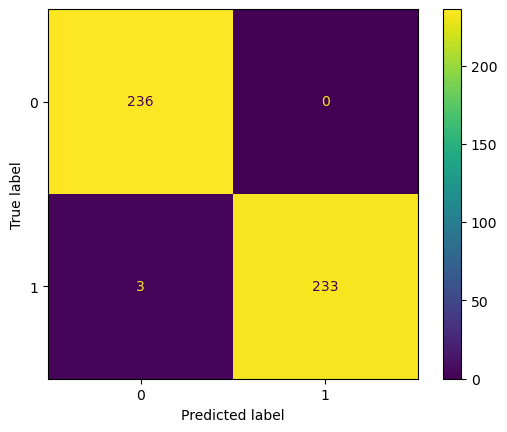

In [7]:
# evaluate against the test set > results to table above in MD

# MLP
model_test_results(X_test, y_test, 'mlp')

### Convolutional Neural Network

CNN 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 214, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 107, 6, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 107, 6, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 105, 4, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 2, 32)         0         
 g2D)                                                            
                                                  

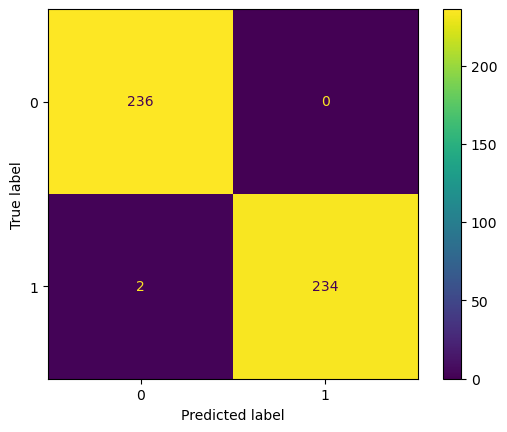

In [8]:
# CNN
model_test_results(X_test, y_test, 'cnn')

### Recurrent Neural Network (Long Short Term Memory)

LSTM 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 216, 64)           19968     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 57217 (223.50 KB)
Trainable params: 57217 (223.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Evaluating

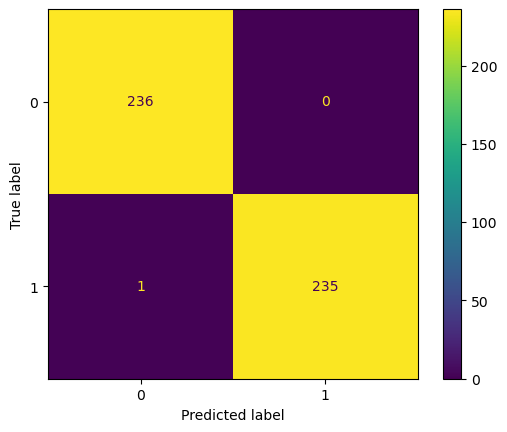

In [9]:
# LSTM
model_test_results(X_test, y_test, 'lstm')

## Environment Evaluation

All six hours of environment recordings have been combined in order to evaluate model performance on "real-world" data. The negative class (no aircraft) outweighs the positive class by a ratio of 5:1 - as such, the "average" parameter used to calculate the F1 score has been set to "weighted" as a means of accounting for the class imbalance of the environmental recordings.

17/17 - 0s - loss: 1.6634 - binary_accuracy: 0.7278 - 301ms/epoch - 18ms/step
135/135 [==============================] - 0s 2ms/step
"MLP" F1 score: 0.7635020859039897



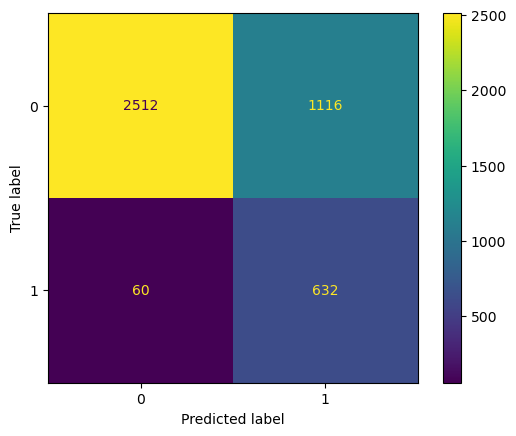

In [10]:
evaluate_env_preds('mlp')

20/20 - 2s - loss: 0.7270 - binary_accuracy: 0.7819 - 2s/epoch - 76ms/step
135/135 [==============================] - 2s 14ms/step
"CNN" F1 score: 0.8082687473710606



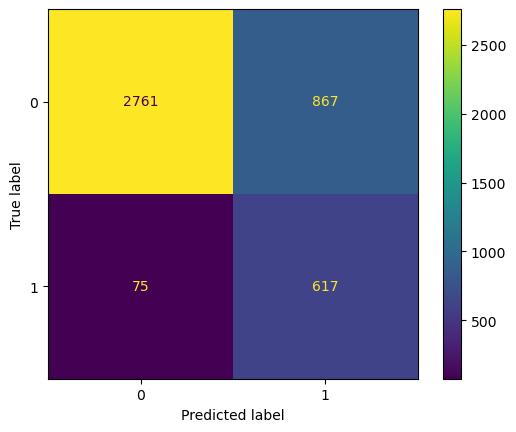

In [11]:
evaluate_env_preds('cnn')

80/80 - 10s - loss: 2.4955 - binary_accuracy: 0.5720 - 10s/epoch - 124ms/step
135/135 [==============================] - 12s 85ms/step
"LSTM" F1 score: 0.6237416521979176



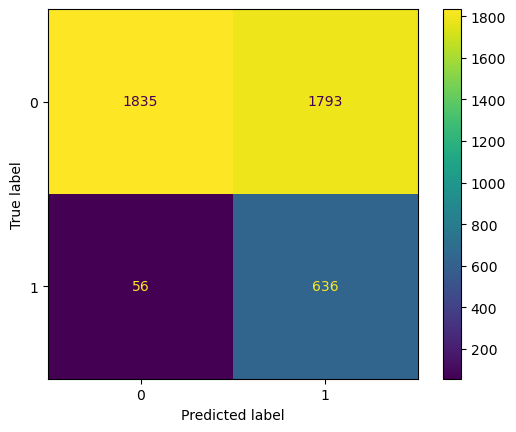

In [12]:
evaluate_env_preds('lstm')

## Plot Environment Predictions per Hour

6 x 1 hour labelled environment recordings have been included with the dataset for model evaluation. The dashed blue line represents the human-labelled "ground-truth" of when an aircraft is audible in the recording. The orange line represents the model's probability of an aircraft being present in each 5 second block of audio. The red line is the threshold at which a probability must pass for a prediction to belong to the positive class.

Plotted below are the outputted probabilities from each model for the same hour of environment recordings. All models performed best on the second hour ("Environment 2"), which can be seen below. Change the parameter "env_n=" to any number from 1 to 6 to inspect model performance for that hour.

3/3 - 0s - loss: 0.1813 - binary_accuracy: 0.9681 - 219ms/epoch - 73ms/step
23/23 [==============================] - 0s 3ms/step
720
360


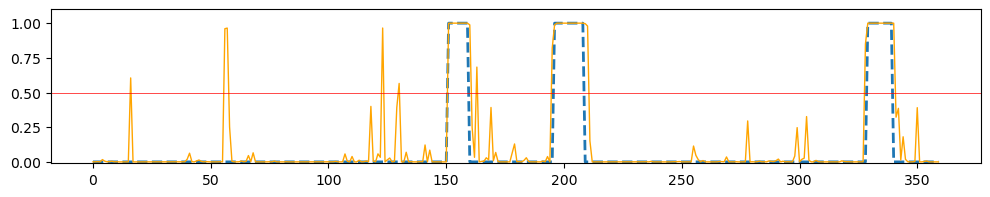

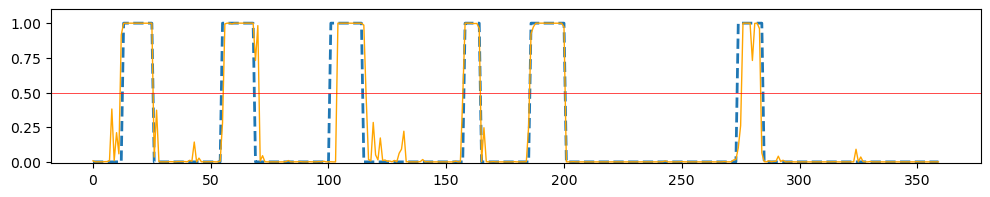

In [13]:
plot_env_preds(env_n=2, short_model_name='mlp')

4/4 - 0s - loss: 0.0621 - binary_accuracy: 0.9778 - 400ms/epoch - 100ms/step
23/23 [==============================] - 0s 14ms/step
720
360


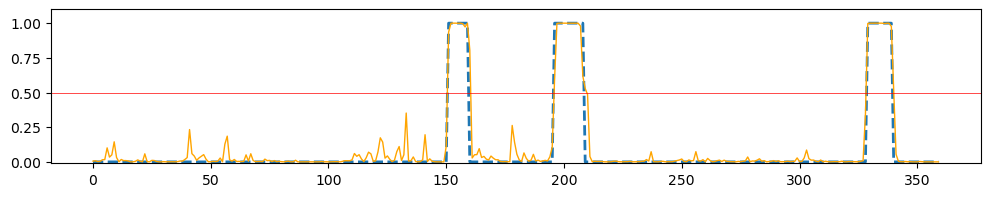

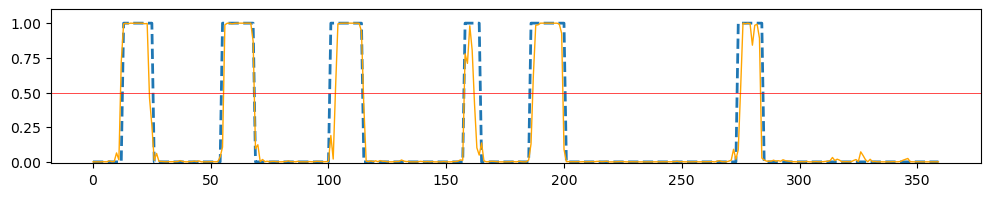

In [14]:
plot_env_preds(2, 'cnn')

14/14 - 2s - loss: 0.9879 - binary_accuracy: 0.8069 - 2s/epoch - 154ms/step
23/23 [==============================] - 3s 76ms/step
720
360


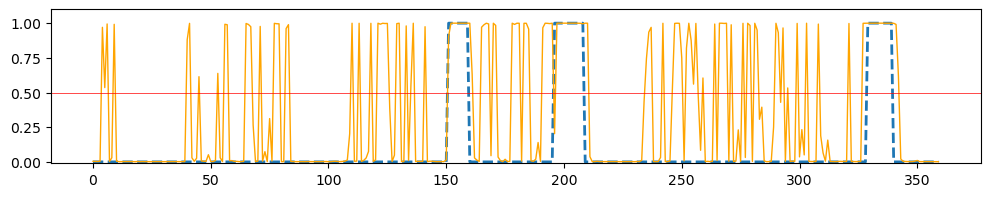

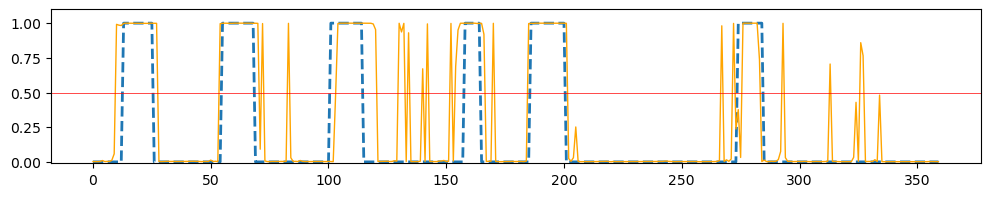

In [15]:
plot_env_preds(2, 'lstm')